In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as lin
from cs771 import plotData as pd, utils, genSyntheticData as gsd
from sklearn.svm import SVC as csvm
from scipy.sparse.linalg import eigsh
import random

# Kernel Ridge Regression

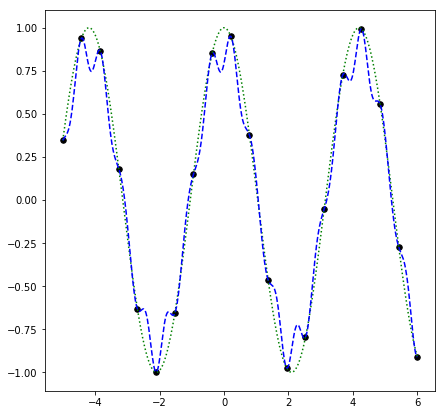

In [3]:
# Get the pairwise kernel values between two sets of feature vectors
# The Gaussian kernel is often called the RBF kernel
# RBF stands for "Radial Basis Function"
def getGramMatrix( X, Y, kernel, p = 1, c = 0, g = 1.0 ):
    # Check if these are 1D datasets
    if len( X.shape ) == 1:
        X = X[:, np.newaxis]
    if len( Y.shape ) == 1:
        Y = Y[:, np.newaxis]
    if kernel == "linear":
        return np.matmul( X, Y.T )
    elif kernel == "poly":
        return np.power( np.matmul( X, Y.T ) + c, p )
    elif kernel == "rbf":
        return np.exp( - g * utils.getAllPairsDistances( X, Y ) )

def getGoldLabel( X ):
    return np.cos( freq * X )

def kernelRR( Xt ):
    Gt = getGramMatrix( Xt, X, kernel, p, c, g )
    return Gt.dot( alpha )
    
n = 20
freq = 1.5
xlimL = -5
xlimR = 6
X = np.linspace( xlimL, xlimR, n, endpoint = True )
y = np.cos( freq * X )

# The behavior of non-linear kernels with different parameter settings is noteworthy
# The linear kernel can only learn a linear model
# Polynomial kernels can learn higher degree polynomials (e.g. quadratics, cubics, quartics etc)
# However, polynomial kernels are unnormalized i.e. K(x,x) can blow up with p and so using a very
# large value of p is not advisable since they can lead to erratic behavior in the kernel
# The RBF kernel is everyone's darling but is a bit temperamental as well and requires a nice
# tuned value of the "bandwidth" parameter (g in this code). If g is set too small, then the RBF
# kernel may behave similar to a linear, low-degree polynomial kernel. If g is set too large, then
# the model learnt merely memorizes the data and is unable to make informative predictions on unseen points
kernel = "rbf"
p = 10
c = 1.0
g = 10
G = getGramMatrix( X, X, kernel, p, c, g )
reg = 0.001
alpha = lin.inv( G + reg * np.identity( n ) ).dot( y )

fig = pd.getFigure()
pd.plot2D( np.hstack( (X[:, np.newaxis], y[:, np.newaxis]) ), fig, color = 'k', marker = 'o', size = 30 )
pd.plotCurve( getGoldLabel, fig, mode = "batch", color = 'g', linestyle = ":", xlimL = xlimL, xlimR = xlimR )
pd.plotCurve( kernelRR, fig, mode = "batch", color = 'b', linestyle = "--", xlimL = xlimL, xlimR = xlimR )

# Kernel Classification

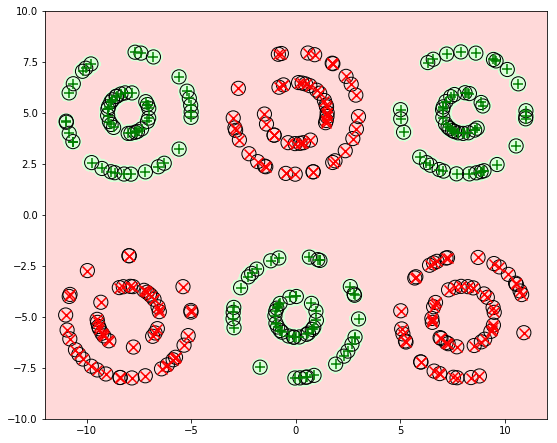

In [4]:
d = 2 
n = 30
r = 3

tmp1 = gsd.genSphericalData( d, n, [-8, 5], r )
tmp2 = gsd.genSphericalData( d, n, [0, -5], r )
tmp3 = gsd.genSphericalData( d, n, [8, 5], r )
tmp4 = gsd.genSphericalData( d, n, [-8, 5], r/3 )
tmp5 = gsd.genSphericalData( d, n, [0, -5], r/3 )
tmp6 = gsd.genSphericalData( d, n, [8, 5], r/3 )
XPos = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5, tmp6) )
yPos = np.ones( (XPos.shape[0],) )

tmp1 = gsd.genSphericalData( d, n, [-8, -5], r )
tmp2 = gsd.genSphericalData( d, n, [0, 5], r )
tmp3 = gsd.genSphericalData( d, n, [8, -5], r )
tmp4 = gsd.genSphericalData( d, n, [-8, -5], r/2 )
tmp5 = gsd.genSphericalData( d, n, [0, 5], r/2 )
tmp6 = gsd.genSphericalData( d, n, [8, -5], r/2 )
XNeg = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5, tmp6) )
yNeg = -np.ones( (XNeg.shape[0],) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

# Similar to regression, the polynomial kernel can help learn non-linear decision boundaries
# e.g. quadratic kernel can help learn conic sections as boundaries. Yet again, the RBF kernel
# should be used with a well-tuned value of g, the bandwidth parameter. If g is set too high,
# the model learnt using RBF kernel will again start memorizing data which is quite useless.
kernel = "rbf"
p = 3
c = 1.0
g = 20
clf = csvm( C = 1.0, kernel = kernel, degree = p, gamma = g, coef0 = c )
clf.fit( X, y )

def kernelCSVMClassifier( X ):
    return clf.predict( X )

fig2 = pd.getFigure( 9, 7.5 )
pd.shade2D( kernelCSVMClassifier, fig2, mode = 'batch', xlim = 12, ylim = 10 )
pd.plot2D( clf.support_vectors_ , fig2, size = 200, color = 'k', marker = 'o', empty = True )
pd.plot2D( XPos, fig2, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig2, color = 'r', marker = 'x' )

# Kernel PCA

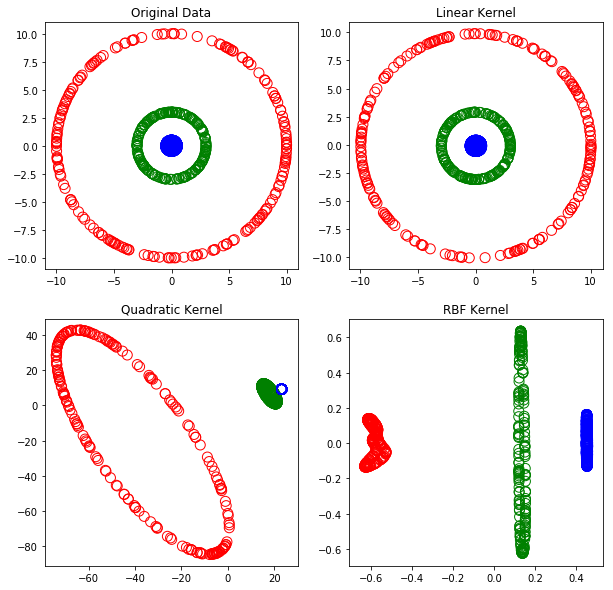

In [5]:
n = 200

X1 = gsd.genSphericalData( d, n, [0, 0], 10 )
X2 = gsd.genSphericalData( d, n, [0, 0], 3 )
X3 = gsd.genSphericalData( d, n, [0, 0], 0.5 )

X = np.vstack( (X1, X2, X3) )

# Center the kernel matrix. This method described in the slides is slow
# and can take O(n^3) time to center an n x n matrix. This is a faster
# ways of doing the same operation in O(n^2) time
def getCenteredKernel( Gt, G ):
    (t,n) = Gt.shape
    Gtcent = Gt - np.sum( Gt, axis = 1 )[:,np.newaxis]/n - np.sum( G, axis = 0 )/n + np.sum( G )/(n*n)
    return Gtcent

def doKPCA( G, k ):
    Gcent = getCenteredKernel( G, G )
    n = G.shape[0]
    init = np.random.normal( 0, 1, (n,) )/np.sqrt( n )
    # eigsh is faster if we require very few components
    sigma, V = eigsh( Gcent, k, v0 = init )
    # Sort eigenvalues in decreasing order
    idx = sigma.argsort()[::-1]
    # Make sure the eigenfunctions are normalized
    alpha = V[:,idx]/np.sqrt( sigma[idx] )
    return alpha

def transform( Gt, G, model ):
    Gcent = getCenteredKernel( Gt, G )
    return np.dot( Gcent, model )
    
fig3, axs3 = pd.getFigList( nrows = 2, ncols = 2, sizex = 5, sizey = 5 )
pd.subplot2D( X1, axs3[0], color = 'r', marker = 'o', empty = True )
pd.subplot2D( X2, axs3[0], color = 'g', marker = 'o', empty = True )
pd.subplot2D( X3, axs3[0], color = 'b', marker = 'o', empty = True )
axs3[0].set_title( "Original Data" )

G = getGramMatrix( X, X, "linear" )
model = doKPCA( G, k = 2 )
pd.subplot2D( transform( getGramMatrix( X1, X, "linear" ), G, model ), axs3[1], color = 'r', marker = 'o', empty = True )
pd.subplot2D( transform( getGramMatrix( X2, X, "linear" ), G, model ), axs3[1], color = 'g', marker = 'o', empty = True )
pd.subplot2D( transform( getGramMatrix( X3, X, "linear" ), G, model ), axs3[1], color = 'b', marker = 'o', empty = True )
axs3[1].set_title( "Linear Kernel" )

p = 2
c = 1.0
G = getGramMatrix( X, X, "poly", p = p, c = c )
model = doKPCA( G, k = 2 )
pd.subplot2D( transform( getGramMatrix( X1, X, "poly", p = p, c = c ), G, model ), axs3[2], color = 'r', marker = 'o', empty = True )
pd.subplot2D( transform( getGramMatrix( X2, X, "poly", p = p, c = c ), G, model ), axs3[2], color = 'g', marker = 'o', empty = True )
pd.subplot2D( transform( getGramMatrix( X3, X, "poly", p = p, c = c ), G, model ), axs3[2], color = 'b', marker = 'o', empty = True )
axs3[2].set_title( "Quadratic Kernel" )

g = 0.05
G = getGramMatrix( X, X, "rbf", g = g )
model = doKPCA( G, k = 2 )
pd.subplot2D( transform( getGramMatrix( X1, X, "rbf", g = g ), G, model ), axs3[3], color = 'r', marker = 'o', empty = True )
pd.subplot2D( transform( getGramMatrix( X2, X, "rbf", g = g ), G, model ), axs3[3], color = 'g', marker = 'o', empty = True )
pd.subplot2D( transform( getGramMatrix( X3, X, "rbf", g = g ), G, model ), axs3[3], color = 'b', marker = 'o', empty = True )
a = axs3[3].set_title( "RBF Kernel" )

# Kernel Clustering

In [6]:
def getGramMatrix( X, Y, kernel, p = 1, c = 0, g = 1.0 ):
    # Check if these are 1D datasets
    if len( X.shape ) == 1:
        X = X[:, np.newaxis]
    if len( Y.shape ) == 1:
        Y = Y[:, np.newaxis]
    if kernel == "linear":
        return np.matmul( X, Y.T )
    elif kernel == "poly":
        return np.power( np.matmul( X, Y.T ) + c, p )
    elif kernel == "rbf":
        return np.exp( - g * utils.getAllPairsDistances( X, Y ) )

# Perform the k-means++ initialization in RKHS in dual form
def doKMPPInit( G, k ):
    n = X.shape[0]
    idx = np.zeros( (k,), dtype = int )
    # Find out the squared Hilbertian (essentially Euclidean) norms of the data points in RKHS
    norms = np.diag( G )
    # Calculate pairwise squared Hilbertian distances in RKHS
    D = - 2 * G + norms + norms[:, np.newaxis]
    # Choose a random data point and make it a centroid
    idx[0] = random.randint( 0, n-1 )
    for t in range( 1, k ):
        # For all data points, find the squared Hilbertian distance to the closest centroid
        dist = np.min( D[:, idx[0:t]], axis = 1 )
        # Choose the next centroid to be one that is likely to be far from all currently chosen centroids
        probs = dist/np.sum(dist)
        # Numerical issues in Python may cause ||x-x||_2 to be not exactly zero
        probs[probs < 1e-10] = 0
        idx[t] = np.random.choice( np.arange( n ), p = probs )
    init = np.zeros( (k, n) )
    init[ np.arange(k), idx ] = 1
    # The following normalization is vacuous since
    # every cluster has just one point at the moment
    init / np.sum( init, axis = 1 )[:,np.newaxis]
    return init, idx

# We know that there are equal number of points per cluster
# as well as how these points are stacked - use this privileged
# info to sample a point from each cluster
# k-means++ should also be able to give such an initialization if 
# the clusters are indeed well-separated, but after several trials
def doCheatInit( G, k ):
    n = G.shape[0]
    nPerClass = n//k
    idx = np.arange( k )*nPerClass + random.randint( 0, nPerClass - 1 )
    init = np.zeros( (k, n) )
    init[ np.arange(k), idx ] = 1
    init / np.sum( init, axis = 1 )[:,np.newaxis]
    return init, idx

# For every point, return which is the closest centroid in terms of Hilbertian distance
def getClosestCentroid( G, alphaVals ):
    k = alphaVals.shape[0]
    n = G.shape[0]
    # Find squared Hilbertian norms of the current centroids
    centroidNorms = np.zeros( (k,) )
    for i in range( k ):
        alphaThisCluster = alphaVals[i,:]
        centroidNorms[i] = alphaThisCluster.dot( G.dot( alphaThisCluster ) )
    # Find the Hilbertian distance of each point from each centroid
    # The first term in the following expression np.diag( G ) is not
    # actually required since it does not affect the argmin at all
    D = np.zeros( (k, n) )
    D = D + np.diag( G ) - 2 * np.matmul( alphaVals, G ) + centroidNorms[:, np.newaxis]
    return np.argmin( D, axis = 0 )

# Update every centroid to the mean of all data points assigned to that cluster
def updateCentroids( G, z, k, prevAlphaVals ):
    alphaVals = np.zeros( (k, G.shape[0]) )
    for i in range( k ):
        if z[z == i].size > 0:
            alphaVals[i, z == i] = 1
            # Normalize the alpha vector
            alphaVals[i,:] = alphaVals[i,:]/np.sum( alphaVals[i,:] )
        # If some cluster is empty, return the old value of its centroid
        else:
            print( "Warning: empty cluster detected" )
            alphaVals[i,:] = prevAlphaVals[i,:]
    if lin.norm( alphaVals - prevAlphaVals, "fro" ) < 1e-15:
        converged = True
        print( "Converged within ", end = '')
    else:
        converged = False
    return (alphaVals, converged)

# Execute the Llyod's algorithm in RKHS
def dokmeans( G, k, init, niter ):
    alphaVals = init
    # Perform alternating minimization for niter steps
    for t in range( niter ):
        z = getClosestCentroid( G, alphaVals )
        alphaVals, conv = updateCentroids( G, z, k, alphaVals )
        if conv:
            print( t, "iterations" )
            return (alphaVals, z)
    return (alphaVals, z)

d = 2
n = 100

X1 = gsd.genSphericalData( d, n, [0, 0], 10 )
X2 = gsd.genSphericalData( d, n, [0, 0], 2)
X = np.vstack( (X1, X2) )

Converged within 1 iterations


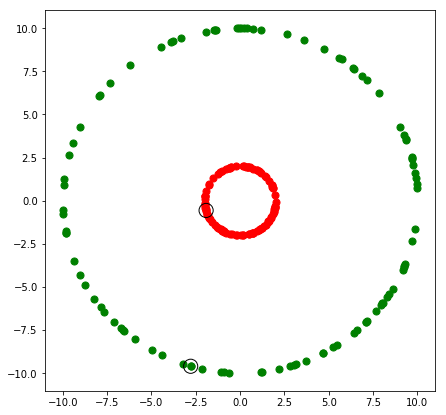

In [7]:
k = 2

G = getGramMatrix( X, X, "rbf", p = 2, c = 1, g = 1.0 )

init, idx = doKMPPInit( G, k )
# Cheating a bit to reduce the number of trials required
# to get good initialization :)
# init, idx = doCheatInit( G, k )
(alphaVals, z) = dokmeans( G, k, init, 100 )

fig = pd.getFigure( 7, 7 )
pd.plot2D( X[z == 0], fig, size = 50, color = 'r', marker = 'o' )
pd.plot2D( X[z == 1], fig, size = 50, color = 'g', marker = 'o' )
# Highlight the points used to initialize kernel k-means
pd.plot2D( X[idx,:] , fig, size = 200, color = 'k', marker = 'o', empty = True )

In [8]:
d = 2
n = 100

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,-2] )

tmp1 = gsd.genMoonData( d, n, mu1, 1 )
tmp2 = gsd.genMoonData( d, n, mu2, 5, flipped = True )
tmp3 = gsd.genMoonData( d, n, mu3, 10 )
X = np.vstack( (tmp1, tmp2, tmp3) )

Converged within 5 iterations


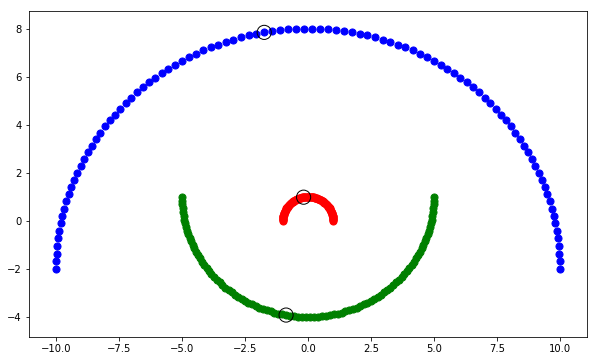

In [10]:
k = 3

G = getGramMatrix( X, X, "rbf", p = 2, c = 1, g = 0.1 )

# init, idx = doKMPPInit( G, k )
# Cheating a bit to reduce the number of trials required
# to get good initialization :)
init, idx = doCheatInit( G, k )
(alphaVals, z) = dokmeans( G, k, init, 100 )

fig = pd.getFigure( 10, 6 )
pd.plot2D( X[z == 0], fig, size = 50, color = 'r', marker = 'o' )
pd.plot2D( X[z == 1], fig, size = 50, color = 'g', marker = 'o' )
pd.plot2D( X[z == 2], fig, size = 50, color = 'b', marker = 'o' )
# Highlight the points used to initialize kernel k-means
pd.plot2D( X[idx,:] , fig, size = 200, color = 'k', marker = 'o', empty = True )